# Training v2.5 with a Deep Q Network (DQN) #

Import statements

In [1]:
import json
import os

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam, SGD

In [3]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory  # For experience replay!

In [4]:
from gym_environment_ncml import *
from learning import *

pygame 2.6.1 (SDL 2.28.4, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Useful numbers

In [5]:
MILLION = 1000000
HTHOUSAND = 100000
THOUSAND = 1000

## 1. Create environment ##

In [6]:
env = GridworldMultiAgentv25()

c:\Users\ANT-PC\.conda\envs\RL\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [7]:
states = env.observation_space.shape[0]
actions = env.action_space.n

In [8]:
states, actions

(10, 25)

## 2. Create a Deep Learning Model with Keras ##

In [9]:
# conv_layers = [(32, (3, 3), (2, 2)), (64, (3, 3), (2, 2))]  # (filters, kernel_size, pool_size)
# model = build_model(states=(84, 84, 3), actions=25, h_nodes=[128, 64], h_act=['relu', 'relu'], use_cnn=True, conv_layers=conv_layers)
model = build_model(states, actions, h_nodes=[128, 64], h_act=['relu', 'leaky_relu'])


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

## 3. Build Agent with Keras-RL ##

In [11]:
def plot_training_metrics(name):
    """
    Visualize training metrics (rewards) for a given agent
    
    Parameters:
    -----------
    name : str
        Name of the agent/training run
    """
    # Load training data
    with open(f'agents/{name}/{name}_training.json', 'r') as f:
        data = json.load(f)
    
    # Create a figure with two subplots
    # plt.figure(figsize=(15, 10))
    
    # Rewards plot
    plt.plot(data['episode_reward'], label='Episode Reward', color='blue', alpha=0.7)
    plt.title(f'Training Rewards for {name}')
    plt.xlabel('Training Steps')
    plt.ylabel('Reward')
    plt.legend()
    
    # Optional: Add moving average for smoother visualization
    window_size = 100
    if len(data['episode_reward']) > window_size:
        rewards_ma = np.convolve(data['episode_reward'], np.ones(window_size)/window_size, mode='valid')
        plt.plot(np.arange(window_size-1, len(data['episode_reward'])), 
                 rewards_ma, label=f'{window_size}-Step Moving Average', color='red', linewidth=2)
        plt.legend()
    
    # # Loss plot
    # plt.subplot(2, 1, 2)
    # plt.plot(data['loss'], label='Training Loss', color='green', alpha=0.7)
    # plt.title(f'Training Loss for {name}')
    # plt.xlabel('Training Steps')
    # plt.ylabel('Loss')
    # plt.legend()
    
    # Adjust layout and save
    # plt.tight_layout()
    plt.savefig(f'agents/{name}/training_metrics_plot.png', dpi=300)
    # plt.close()

    # Optional: Print some basic statistics
    print(f"Reward Statistics for {name}:")
    print(f"Mean Reward: {np.mean(data['episode_reward']):.2f}")
    print(f"Max Reward: {np.max(data['episode_reward']):.2f}")
    print(f"Min Reward: {np.min(data['episode_reward']):.2f}")


In [12]:
dqn = build_agent(model, actions, 0.01, EpsGreedyQPolicy(), 50000)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
# dqn.compile(Adam(lr=1e-2), metrics=['mse'])

c:\Users\ANT-PC\.conda\envs\RL\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
# name = 'dqn25_5b5_3216_adam_lr0.001_tmu0.01_ml50K_ns5M_eps0.1_a6_b0'
name = 'DQN_complex_5HT'

In [14]:
history = dqn.fit(env, nb_steps=5*HTHOUSAND, visualize=False, verbose=1)

Training for 500000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 13:49 - reward: -1.0000

c:\Users\ANT-PC\.conda\envs\RL\lib\site-packages\keras\engine\training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 47s 5ms/step - reward: -0.8464
200 episodes - episode_reward: -42.320 [-58.000, 8.000] - loss: 297920.954 - mae: 139.026 - mean_q: 222.689

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 49s 5ms/step - reward: -0.9008
200 episodes - episode_reward: -45.040 [-64.000, -8.000] - loss: 2867943.250 - mae: 601.535 - mean_q: 993.887

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 48s 5ms/step - reward: -0.8912
200 episodes - episode_reward: -44.560 [-64.000, -10.000] - loss: 43700640.000 - mae: 1988.961 - mean_q: 3602.073

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 49s 5ms/step - reward: -0.8850
200 episodes - episode_reward: -44.250 [-58.000, -16.000] - loss: 184223984.000 - mae: 3812.541 - mean_q: 7140.263

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 50s 5ms/step - reward: -0.9032
200 episodes - epis

In [15]:
data = history.history
data['episode_reward'] = [float(v) for v in data['episode_reward']]
data['nb_episode_steps'] = [int(v) for v in data['nb_episode_steps']]
data['nb_steps'] = [int(v) for v in data['nb_steps']]

In [16]:
os.mkdir('agents/{}'.format(name))  # If the directory does not exist we cannot write the file
with open(get_training_path(name), 'w') as f:
    json.dump(data, f)

Save agent to memory

In [17]:
dqn.save_weights(get_agent_path(name), overwrite=True)

Reward Statistics for DQN_complex_5HT:
Mean Reward: -44.93
Max Reward: 10.00
Min Reward: -66.00


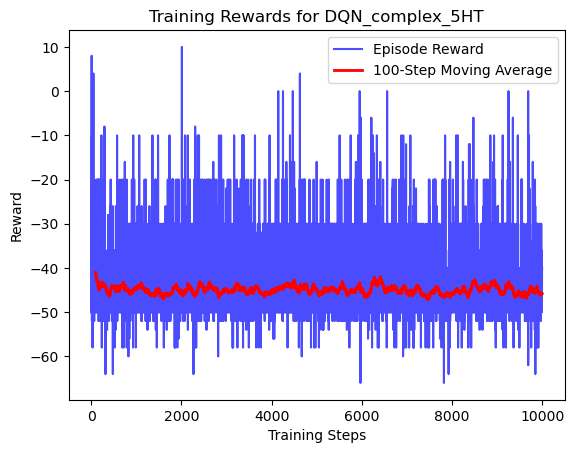

In [25]:
plot_training_metrics('DQN_complex_5HT')

In [ ]:
plt.plot(data['episode_reward'], label='Episode Reward', color='blue', alpha=0.7)
plt.title(f'Training Rewards for {name}')
plt.xlabel('Training Steps')
plt.ylabel('Reward')
plt.legend()

## 4. Reloading training from and test ##

In [19]:
env = GridworldMultiAgentv25(seed=2)

In [20]:
states = env.observation_space.shape[0]
actions = env.action_space.n
model = build_model(states, actions, h_nodes=[128, 64], h_act=['relu', 'leaky_relu'])

print(model.summary())
dqn = build_agent(model, actions, 0.01, EpsGreedyQPolicy(eps=0), 50000)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Load weights
dqn.load_weights(get_agent_path(name))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               1408      
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                      

In [21]:
nb_episodes = 10*THOUSAND

In [22]:
scores = dqn.test(env, nb_episodes=nb_episodes, visualize=False, verbose=0)

In [23]:
rewards = np.array(scores.history['episode_reward'])

In [24]:
np.savetxt(get_test_path(name, nb_episodes), rewards)